# SVD

In [13]:
from typing import Tuple, Callable

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import os

In [14]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
#DATA_DIR = "/cluster/courses/cil/collaborative_filtering/data"
DATA_DIR = "/home/Soufiane/Desktop/CIL/BayesWatch_CollaborativeFiltering/Data/"

## Helper methods

In [15]:
def read_data_df() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Reads in data."""
    
    df = pd.read_csv(os.path.join(DATA_DIR, "train_ratings.csv"))
    implicit_df = pd.read_csv(os.path.join(DATA_DIR, "train_tbr.csv"))

    # Split sid_pid into sid and pid columns
    df[["sid", "pid"]] = df["sid_pid"].str.split("_", expand=True)
    df = df.drop("sid_pid", axis=1)
    df["sid"] = df["sid"].astype(int)
    df["pid"] = df["pid"].astype(int)
    implicit_df["sid"] = implicit_df["sid"].astype(int)
    implicit_df["pid"] = implicit_df["pid"].astype(int)
    
    return df, implicit_df


def read_data_matrix(df: pd.DataFrame) -> np.ndarray:
    """Returns matrix view of the training data"""

    return df.pivot(index="sid", columns="pid", values="rating").values


def evaluate(valid_df: pd.DataFrame, pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> float:
    """
    Inputs:
        valid_df: Validation data, returned from read_data_df for example.
        pred_fn: Function that takes in arrays of sid and pid and outputs their rating predictions.

    Outputs: Validation RMSE
    """
    
    preds = pred_fn(valid_df["sid"].values, valid_df["pid"].values)
    return root_mean_squared_error(valid_df["rating"].values, preds)


def make_submission(pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray], filename: os.PathLike):
    """Makes a submission CSV file that can be submitted to kaggle.

    Inputs:
        pred_fn: Function that takes in arrays of sid and pid and outputs a score.
        filename: File to save the submission to.
    """
    
    df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

    # Get sids and pids
    sid_pid = df["sid_pid"].str.split("_", expand=True)
    sids = sid_pid[0]
    pids = sid_pid[1]
    sids = sids.astype(int).values
    pids = pids.astype(int).values
    
    df["rating"] = pred_fn(sids, pids)
    df.to_csv(filename, index=False)

In [16]:
def impute_implicit_values(mat: np.ndarray, implicit_tuples: np.ndarray) -> np.ndarray:
    means = np.nanmean(mat, axis=1)
    for (sid, pid) in implicit_tuples:
        mat[sid][pid] = means[sid]
    return mat

def impute_other_values(mat: np.ndarray, value) -> np.ndarray:
    return np.nan_to_num(mat, nan=value)

def impute_avg_values(mat: np.ndarray, mat_to_impute: np.ndarray) -> np.ndarray:
    paper_avgs = np.nanmean(mat, axis=0)
    for col in range(len(paper_avgs)):
        np.nan_to_num(mat_to_impute[:,col], nan=paper_avgs[col], copy=False)
    return mat_to_impute
    
    

In [17]:
def opt_rank_k_approximation(m: np.ndarray, k: int):
    """Returns the optimal rank-k reconstruction matrix, using SVD."""
    
    assert 0 < k <= np.min(m.shape), f"The rank must be in [0, min(m, n)]"
    
    U, S, Vh = np.linalg.svd(m, full_matrices=False)
    
    U_k = U[:, :k]
    S_k = S[:k]
    Vh_k = Vh[:k]
    
    return np.dot(U_k * S_k, Vh_k)


def matrix_pred_fn(train_recon: np.ndarray, sids: np.ndarray, pids: np.ndarray) -> np.ndarray:
    """
    Input:
        train_recon: (M, N) matrix with predicted values for every (sid, pid) pair.
        sids: (D,) vector with integer scientist IDs.
        pids: (D,) vector with integer paper IDs.
        
    Outputs: (D,) vector with predictions.
    """
    
    return train_recon[sids, pids]

## Strategies Test Ground

In [18]:
# READ data
explcit_data, implicit_data  = read_data_df()
# SPLIT data
train_df, valid_df = train_test_split(explcit_data, test_size=0.20)
# Transforming data format
train_mat = read_data_matrix(train_df)
implicit_tuples = implicit_data.apply(lambda row: (row['sid'], row['pid']), axis=1).to_numpy()

In [19]:
# Impute missing values
train_mat_imputed = impute_implicit_values(train_mat.copy(), implicit_tuples)
#impute_value = 3
#train_mat_imputed = impute_other_values(train_mat_imputed, impute_value)
train_mat_imputed = impute_avg_values(train_mat, train_mat_imputed)

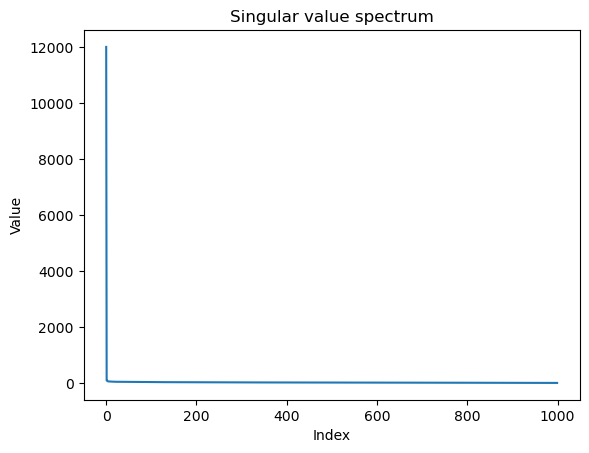

[12009.29034714    99.43439977    95.25936       75.5332703
    69.26380297    66.04861376    64.72593884    63.18283959
    62.62156462    61.62454453    61.52633482    60.1544682
    60.00936094    58.47297594    58.05285399    57.12445377
    56.59426195    55.99610347    55.79022018    55.0411569
    55.02246197    54.49665374    54.47777021    53.55849346
    53.39361356    53.23664428    52.93791135    52.63589736
    52.52407338    52.13872729    51.77722563    51.62346123
    51.50672479    51.38966707    51.25177688    51.00356968
    50.62186694    50.38164968    50.08181843    49.98301228
    49.77026318    49.5529365     49.40619118    49.28526513
    49.01640426    48.8454553     48.64574328    48.53833271
    48.34395416    48.27982914    48.00657887    47.77585525
    47.63536216    47.5408358     47.31044499    47.20511314
    47.04110243    47.00270716    46.84530434    46.70886459
    46.55053007    46.31968866    46.2437037     46.07327174
    45.92382822    45.86980

In [21]:
#Plot singluar values
singular_values = np.linalg.svd(train_mat_imputed, compute_uv=False, hermitian=False)
plt.plot(singular_values)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Singular value spectrum")
plt.show()
print(singular_values)

In [28]:
# Optimal rank k reconstruction
train_recon = opt_rank_k_approximation(train_mat_imputed, k=20)

In [29]:
pred_fn = lambda sids, pids: matrix_pred_fn(train_recon, sids, pids)

# Evaluate on validation data
val_score = evaluate(valid_df, pred_fn)
print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 0.926


## Analysis and Cross validation over HyperParameters

In [6]:
# READ data
explcit_data, implicit_data  = read_data_df()
# SPLIT data
train_df, valid_df = train_test_split(explcit_data, test_size=0.20)

implicit_tuples = implicit_data.apply(lambda row: (row['sid'], row['pid']), axis=1).to_numpy()

In [7]:
# Define the range of candidate parameter values for k and impute_value
k_values = range(2, 21)          
impute_values = [x / 10.0 for x in range(0, 55, 5)]

# Create an array to store validation RMSE results for each parameter combination.
results = np.zeros((len(k_values), len(impute_values)))

#Get the original training data matrix (which still has NaNs) 
train_mat_orig = read_data_matrix(train_df)
# Loop over each combination of k and impute_value.
for i, k in enumerate(k_values):
    for j, imp_val in enumerate(impute_values):

        # Impute implicit entries 
        train_mat_temp = impute_implicit_values(train_mat_orig.copy(), implicit_tuples)
        
        # impute the remaining missing values
        train_mat_temp = impute_other_values(train_mat_temp, imp_val)
        
        # Compute the rank-k approximation of the imputed matrix
        train_recon = opt_rank_k_approximation(train_mat_temp, k=k)
        
        # define the prediction function based on the reconstructed matrix
        pred_fn = lambda sids, pids: matrix_pred_fn(train_recon, sids, pids)
        
        # Evaluate
        rmse = evaluate(valid_df, pred_fn)
        results[i, j] = rmse
        
        print(f"k = {k}, impute_value = {imp_val} -> Validation RMSE: {rmse:.3f}")

# find the parameter combination with the lowest RMSE.
best_idx = np.unravel_index(np.argmin(results, axis=None), results.shape)
best_k = k_values[best_idx[0]]
best_impute_val = impute_values[best_idx[1]]
print(f"\nBest parameters found: k = {best_k}, impute_value = {best_impute_val} with RMSE = {results[best_idx]:.3f}")


k = 2, impute_value = 0.0 -> Validation RMSE: 3.284
k = 2, impute_value = 0.5 -> Validation RMSE: 2.889
k = 2, impute_value = 1.0 -> Validation RMSE: 2.504
k = 2, impute_value = 1.5 -> Validation RMSE: 2.130
k = 2, impute_value = 2.0 -> Validation RMSE: 1.774
k = 2, impute_value = 2.5 -> Validation RMSE: 1.447
k = 2, impute_value = 3.0 -> Validation RMSE: 1.177
k = 2, impute_value = 3.5 -> Validation RMSE: 1.008
k = 2, impute_value = 4.0 -> Validation RMSE: 0.995
k = 2, impute_value = 4.5 -> Validation RMSE: 1.143
k = 2, impute_value = 5.0 -> Validation RMSE: 1.397
k = 3, impute_value = 0.0 -> Validation RMSE: 3.243
k = 3, impute_value = 0.5 -> Validation RMSE: 2.854
k = 3, impute_value = 1.0 -> Validation RMSE: 2.474
k = 3, impute_value = 1.5 -> Validation RMSE: 2.106
k = 3, impute_value = 2.0 -> Validation RMSE: 1.755
k = 3, impute_value = 2.5 -> Validation RMSE: 1.434
k = 3, impute_value = 3.0 -> Validation RMSE: 1.169
k = 3, impute_value = 3.5 -> Validation RMSE: 1.003
k = 3, imput

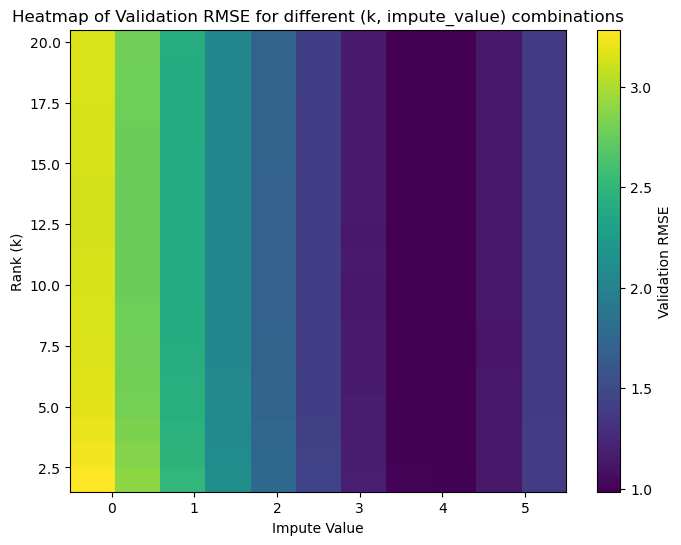

In [8]:
#Plot

plt.figure(figsize=(8, 6))
# Create a heatmap: the x-axis represents impute_value and the y-axis represents k
im = plt.imshow(
    results, 
    origin='lower', 
    aspect='auto',
    extent=[min(impute_values)-0.5, max(impute_values)+0.5, min(k_values)-0.5, max(k_values)+0.5],
    cmap='viridis'
)
plt.colorbar(im, label='Validation RMSE')
plt.xlabel('Impute Value')
plt.ylabel('Rank (k)')
plt.title('Heatmap of Validation RMSE for different (k, impute_value) combinations')
plt.show()


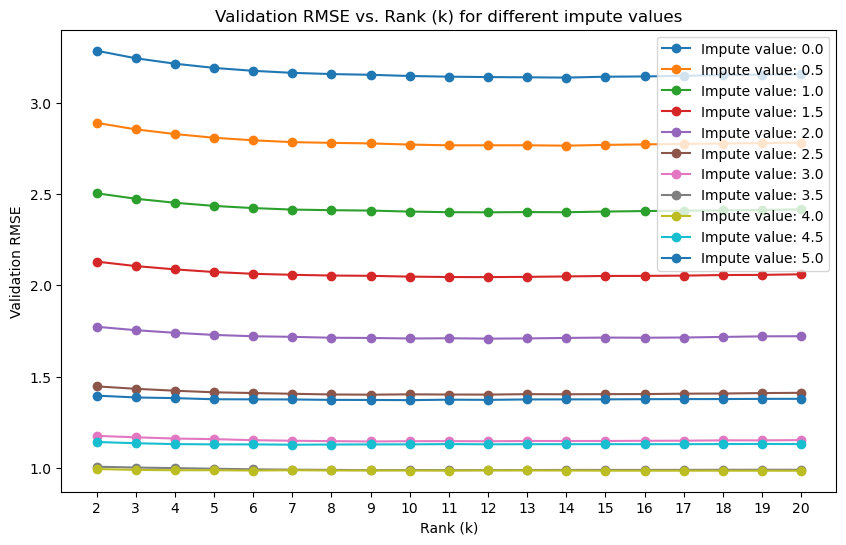

In [11]:
plt.figure(figsize=(10, 6))
for j, imp_val in enumerate(impute_values):
    plt.plot(k_values, results[:, j], marker='o', label=f"Impute value: {imp_val}")
plt.xticks(k_values)
plt.xlabel("Rank (k)")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE vs. Rank (k) for different impute values")
plt.legend()
plt.show()


In [12]:
# Train on full Data using the optimal parameter and create the submission file

# Full data
explcit_data, implicit_data  = read_data_df()
train_mat = read_data_matrix(explcit_data)
#impute
train_mat_temp = impute_implicit_values(train_mat_orig.copy(), implicit_tuples)
train_mat_temp = impute_other_values(train_mat_temp, best_impute_val) #use best value

# Compute the rank-k approximation of the imputed matrix
train_recon = opt_rank_k_approximation(train_mat_temp, k=best_k) # use best k

# define the prediction function based on the reconstructed matrix
pred_fn = lambda sids, pids: matrix_pred_fn(train_recon, sids, pids)

# submission file
make_submission(pred_fn, "svd_submission.csv")
